In [1]:
# Some neccessary Libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
%load_ext tensorboard

In [2]:
# Load the IRIS Dataset
iris = pd.read_csv('iris.csv')
iris.head() 

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [3]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
iris.describe() # Statistical summary of the iris dataset

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
# Check for missing value
iris.isnull().sum()/len(iris)*100

Sepal.Length    0.0
Sepal.Width     0.0
Petal.Length    0.0
Petal.Width     0.0
Species         0.0
dtype: float64

As you can see the result , there are no missing values

# Vizualization of the data

Text(0.5, 1.0, 'Distribution of Types of Species')

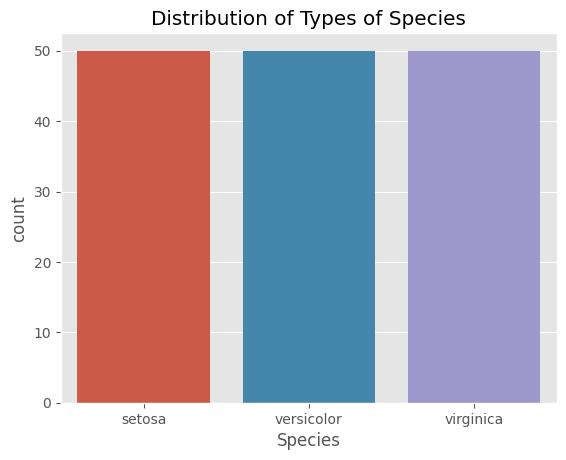

In [6]:
# Target Variable 
plt.style.use('ggplot')
sns.countplot(data = iris , x = 'Species')
plt.title('Distribution of Types of Species')

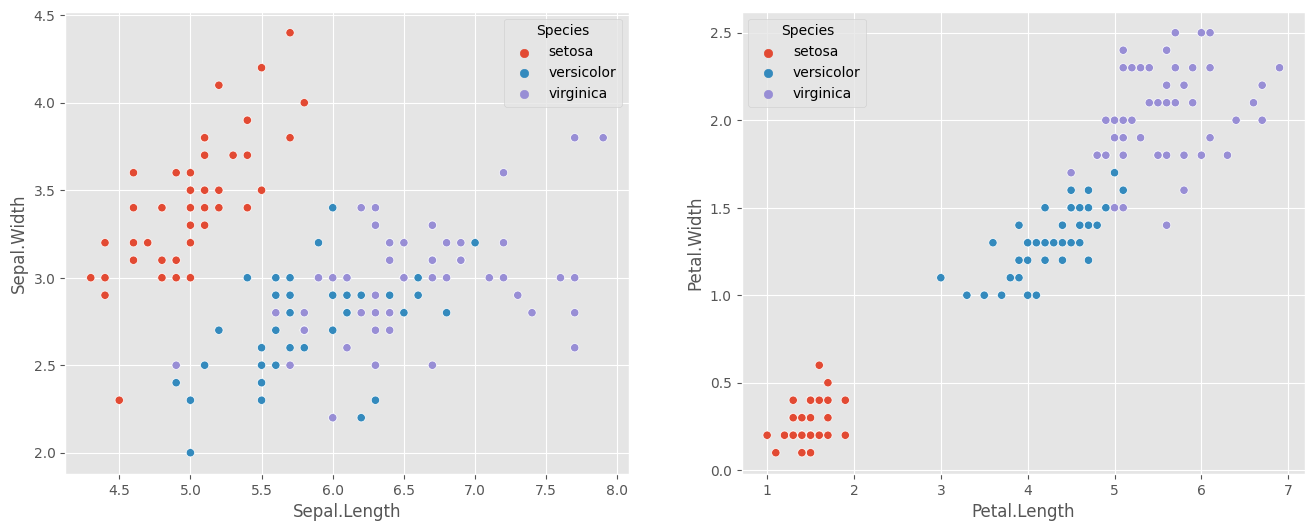

In [7]:
# Visualizing species based on Sepal length and width OR Petal Length and Petal Width
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(data = iris , x = 'Sepal.Length' , y = 'Sepal.Width' , hue='Species')

plt.subplot(1, 2, 2)

sns.scatterplot(data = iris , x = 'Petal.Length' , y = 'Petal.Width' , hue='Species')

plt.show()


We can easily differentiate setosa based on Sepal but for versicolor and virginica its difficult because the data is scattred.

### Data preprocessing Steps

In [8]:
# Split data into target & predictors
X = iris.iloc[: , :4]
y = iris.iloc[: , -1]

In [9]:
# One hot encoding
enc = OneHotEncoder()
Y = enc.fit_transform(np.array(y).reshape(-1, 1)).toarray()

In [10]:
# Standard Scaling ,important for convergence of the neural network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Split the dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=4)

n_features = X.shape[1]
n_classes = Y.shape[1]

In [12]:
# neural network architecture for adaptive activation function (AF) selection

initializer0 = keras.initializers.RandomUniform(minval = -0.01, maxval =0.1)
initializer1 = keras.initializers.RandomUniform(minval = -0.01, maxval =0.1)
initializer2 = keras.initializers.RandomUniform(minval = 0.5, maxval =1.5)

class Ada_act(keras.layers.Layer):
    def __init__(self):
        super(Ada_act, self).__init__()
        self.k0 = self.add_weight(name='k0', shape = (), initializer=initializer0, trainable=True)
        self.k1 = self.add_weight(name='k1', shape = (), initializer=initializer1, trainable=True)
        self.k2 = self.add_weight(name='k2', shape = (), initializer=initializer2, trainable=True)
        
    def call(self, inputs):
        return self.k0 + tf.multiply(inputs, self.k1) + tf.multiply(tf.multiply(inputs,inputs), self.k2)

In [13]:
# Build model with fully connected layers with dropout regulation
model = Sequential()
model.add(layers.Dense(25, input_dim=X.shape[1]))
act = Ada_act()
model.add(act)
model.add(layers.Dropout(0.1))
model.add(layers.Dense(Y.shape[1], activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                125       
                                                                 
 ada_act (Ada_act)           (None, 25)                3         
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 78        
                                                                 
Total params: 206
Trainable params: 206
Non-trainable params: 0
_________________________________________________________________


In [14]:
import datetime
batch_size = 5
epochs = 100

model.compile(loss="categorical_crossentropy", optimizer = keras.optimizers.Adam(learning_rate = 0.001), metrics=["accuracy"])

log_dir = "irislogs/smallk1k0/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2 ,callbacks=[tensorboard_callback], verbose=1)

Epoch 1/100
20/20 [==============================] - 4s 49ms/step - loss: 1.0369 - accuracy: 0.4062 - val_loss: 1.2974 - val_accuracy: 0.2917
Epoch 2/100
20/20 [==============================] - 0s 15ms/step - loss: 0.9736 - accuracy: 0.4583 - val_loss: 1.1193 - val_accuracy: 0.4167
Epoch 3/100
20/20 [==============================] - 0s 14ms/step - loss: 0.8965 - accuracy: 0.6042 - val_loss: 1.0007 - val_accuracy: 0.5833
Epoch 4/100
20/20 [==============================] - 0s 14ms/step - loss: 0.8199 - accuracy: 0.7083 - val_loss: 0.9139 - val_accuracy: 0.6250
Epoch 5/100
20/20 [==============================] - 0s 14ms/step - loss: 0.7913 - accuracy: 0.7188 - val_loss: 0.8013 - val_accuracy: 0.7083
Epoch 6/100
20/20 [==============================] - 0s 13ms/step - loss: 0.7479 - accuracy: 0.7396 - val_loss: 0.7311 - val_accuracy: 0.8333
Epoch 7/100
20/20 [==============================] - 0s 15ms/step - loss: 0.6885 - accuracy: 0.7604 - val_loss: 0.6584 - val_accuracy: 0.8333
Epoch 

In [31]:
# parameter updates during training
parameter_updates = history.history['loss']
print(parameter_updates)

[1.0368801355361938, 0.9736173748970032, 0.8964828848838806, 0.81990647315979, 0.7912871837615967, 0.7478959560394287, 0.6884776949882507, 0.6519716382026672, 0.6125746369361877, 0.5522581934928894, 0.5284008383750916, 0.4983959197998047, 0.45869266986846924, 0.42497703433036804, 0.4036462604999542, 0.382389634847641, 0.38142839074134827, 0.36813822388648987, 0.34204575419425964, 0.328821063041687, 0.30623993277549744, 0.28228750824928284, 0.26399779319763184, 0.2650189697742462, 0.26166197657585144, 0.2532854974269867, 0.21423371136188507, 0.21703024208545685, 0.19256092607975006, 0.1775403618812561, 0.15763242542743683, 0.15220306813716888, 0.15182295441627502, 0.13683199882507324, 0.12407535314559937, 0.12867549061775208, 0.11789164692163467, 0.09685149043798447, 0.10434537380933762, 0.09889128059148788, 0.09396856278181076, 0.09148944169282913, 0.09259706735610962, 0.08230830729007721, 0.08599420636892319, 0.08072876930236816, 0.06098219379782677, 0.06642164289951324, 0.06102881953

In [33]:
# final parameter values at the end of training
final_parameter_values = model.get_weights()
print(final_parameter_values)

[array([[ 3.36518914e-01,  9.45661624e-04,  1.29958183e-01,
         4.64792848e-02, -6.01450875e-02, -9.79695916e-02,
        -2.69006751e-02,  8.71275514e-02, -7.75232017e-01,
         1.03833731e-02, -3.25446159e-01, -4.07428481e-02,
         2.18180522e-01,  3.95352602e-01,  3.14585827e-02,
        -2.31266856e-01, -2.41660755e-02,  5.45036376e-01,
        -8.19759741e-02,  8.89247805e-02, -2.61368692e-01,
         9.33054835e-03,  1.84734672e-01,  3.12190175e-01,
         1.05926715e-01],
       [ 2.85480712e-02,  2.39328340e-01, -5.39144933e-01,
        -7.25233040e-05, -4.69962955e-01, -4.90437269e-01,
         2.05628708e-01, -4.55864757e-01,  4.85984445e-01,
        -3.95757169e-01, -2.16085583e-01, -1.46059468e-01,
         4.19139862e-01,  2.95978487e-01,  5.70053644e-02,
        -9.87346657e-03,  5.04915893e-01, -3.49239469e-01,
        -2.67708868e-01, -1.44502044e-01,  5.88758662e-02,
         2.38620773e-01, -2.42737293e-01, -2.26352841e-01,
         2.86231518e-01],
   

In [34]:
total_parameters = model.count_params()
print(total_parameters)

206


In [15]:
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.14373429119586945
Test accuracy: 0.9333333373069763


In [38]:
# Optimal Value of k0,k1 & k2
print("AF coefficients (weights) {}".format(act.get_weights()))

AF coefficients (weights) [-0.50128835, -0.27183107, 1.6314266]


In [17]:
from sklearn.metrics import f1_score
# training and test loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

In [37]:
print(train_loss[-1])

0.028986701741814613


In [18]:
# training and testing accuracy
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

In [35]:
print(train_accuracy[-1])

0.9791666865348816


In [20]:
# predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

1/1 [==============================] - 0s 222ms/step


In [21]:
#  F1-Score
f1 = f1_score(np.argmax(Y_test, axis=1), y_pred, average='weighted')

In [22]:
# Print test loss, test accuracy, and F1-Score
score = model.evaluate(X_test, Y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
print("F1-Score:", f1)

Test loss: 0.14373429119586945
Test accuracy: 0.9333333373069763
F1-Score: 0.9333333333333333


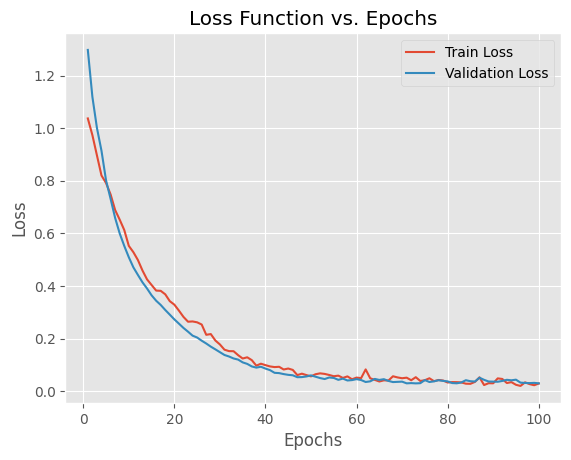

In [23]:
# Plot of loss function vs. epochs
plt.plot(range(1, epochs + 1), train_loss, label='Train Loss')
plt.plot(range(1, epochs + 1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs')
plt.legend()
plt.show()